# <center> **ДИПЛОМНАЯ РАБОТА**
# <center> **на тему:** 
# <center> <U>**Бриф «Лаборатории исследований гражданского общества».**
# <center> **Государственные деньги у НКО**</U>

# *Описание проекта*
В распоряжении есть дамп данных обо всех НКО России,  
в котором содержится информация о получении государственных грантов,  
госконтрактов и субсидий, регионе и дате регистрации,  
а также ОКВЭД (классификатор экономической деятельности).
# *Постановка задачи*
Проверить, есть ли зависимость вероятности получения грантов от государства/госконтрактов:  
➔ от региона регистрации организации;  
➔ от возраста организации;  
➔ от экономической деятельности организации.  
По желанию можно провести любые дополнительные проверки.
# *Исходные данные*
Источник данных — проект «Открытые НКО» <https://openngo.ru/>  
Дамп данных в формате JSON (актуален на 16.08.2023) <https://openngo.ru/opendata/>  
Описание полей на GitHub <https://github.com/infoculture/openngo-data-reference/wiki/Характеристики-и-расшифровки-открытых-данных>

## Библиотеки

In [1]:
# общие библиотеки
import pandas as pd # для работы с данными
import numpy as np  # для выполнения научных вычислений
import ast # для безопасного преобразования строки в список с помощью функции literal_eval()
import json # для работы с данными в формате JSON
from datetime import datetime # для работы датой и временем
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# для формирования моделей
from sklearn.model_selection import train_test_split # для разделения датасета
from sklearn import linear_model # линейные модели
from sklearn import ensemble # ансамбли
from sklearn.model_selection import GridSearchCV # для поиска наилучших гиперпараметров

# метрики
from sklearn import metrics #метрики
from sklearn.metrics import precision_score

## Глава 1. Анализ исходных данных

Исходные данные представляют собой 16 файлов формата JSON.  
 
Анализ исходных данных представляет собой:
1. сбор 16 файлов формата JSON в единый DataFrame
2. анализ количества строк, типов данных, пропущенных данных
3. удаление признаков, однозначно не повлияющих на дальнейшее решение задачи

In [2]:
# сбор 16 файлов формата JSON в единый DataFrame

data_list = [] # список данных

# Прочитать каждый файл JSON и добавить его данные в список
for i in range(1, 17):
    filename = f"data/ngo_dump_{i:02d}.json"  # Имя файла в формате "ngo_dump_01.json" до "ngo_dump_16.json"
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # Преобразовать каждую строку в объект JSON
    for line in lines:
        data = json.loads(line)
        data_list.append(data)

# Преобразовать список объектов JSON в DataFrame
df_full = pd.DataFrame(data_list)
df_full.head(2)

,addOkved,address,chiefs,dateLiquid,dateOgrn,dateReg,email,fullName,inn,kpp,...,okato,okfs,okogu,oktmo,socialMedia,opfType,reports,incomeTotal,incomeDetail,incomeRank
0,"[{'code': '72.4', 'name': 'Деятельность по соз...","422430, РЕСПУБЛИКА ТАТАРСТАН, ГОРОД БУИНСК, УЛ...","[{'name': 'ХАЛИКОВ РАШИТ РИНАТОВИЧ', 'title': ...",{'$date': '2012-12-17T00:00:00.000Z'},{'$date': '2010-03-03T00:00:00.000Z'},None,None,"НЕКОММЕРЧЕСКОЕ ПАРТНЕРСТВО ""ИНФОРМАЦИОННО-КОНС...",1614010370,161401001,...,"{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'facebook': None, 'instagram': None, 'ok': No...",Некоммерческие партнерства,[],0.0,"{'grants': {'totalCount': 0, 'totalSum': 0}, '...",Наличие доходов из доступных источников не уст...
1,"[{'code': '67.20.2', 'name': 'Деятельность спе...","430030, РЕСПУБЛИКА МОРДОВИЯ, ГОРОД САРАНСК, УЛ...","[{'name': 'ПУЗАНОВ ВЛАДИМИР ВЛАДИМИРОВИЧ', 'ti...",{'$date': '2014-11-10T00:00:00.000Z'},{'$date': '2010-05-11T00:00:00.000Z'},None,None,"НЕКОММЕРЧЕСКОЕ ПАРТНЕРСТВО ""МЕЖРЕГИОНАЛЬНЫЙ НА...",1327010633,132701001,...,"{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'code': None, 'name': None}","{'facebook': None, 'instagram': None, 'ok': No...",Некоммерческие партнерства,"[{'type': 'Заявление', 'reportId': '19445801',...",0.0,"{'grants': {'totalCount': 0, 'totalSum': 0}, '...",Наличие доходов из доступных источников не уст...


In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752072 entries, 0 to 752071
Data columns (total 40 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   addOkved            752072 non-null  object 
 1   address             752072 non-null  object 
 2   chiefs              752072 non-null  object 
 3   dateLiquid          406460 non-null  object 
 4   dateOgrn            752072 non-null  object 
 5   dateReg             321581 non-null  object 
 6   email               11086 non-null   object 
 7   fullName            752072 non-null  object 
 8   inn                 749468 non-null  object 
 9   kpp                 748411 non-null  object 
 10  mainOkved           752072 non-null  object 
 11  ogrn                752072 non-null  object 
 12  opf                 752072 non-null  object 
 13  predecessors        752072 non-null  object 
 14  shortName           602778 non-null  object 
 15  statusInfo          752072 non-nul

In [4]:
# Перечень признаков с пропущенными данными
missing_columns = df_full.columns[df_full.isnull().any()]
for column in missing_columns:
    missing_count = df_full[column].isnull().sum()
    print(f"'{column}': {missing_count}")

'dateLiquid': 345612
'dateReg': 430491
'email': 740986
'inn': 2604
'kpp': 3661
'shortName': 149294
'foundersConfig': 480724
'regionName': 25
'minjustForm': 285495
'minjustStatus': 285495
'minjustRegNum': 285495
'okpo': 406694
'hasRegionalSupport': 752072
'website': 746785
'website_punycode': 746785


Рассмотрим столбцы/признаки, значение которых объективно не могут влияют на поставленную задачу, на целевой признак "incomeTotal" - сумма доходов:
1. chiefs: руководители организации (не будем рассматривать вариант влияния субъекта на целевой признак, иными словами коррупцию) 
2. email: email организации
3. shortName: сокращенное наименование организации
4. inn
5. kpp
6. regionName: название региона организации (есть признак "regionCode" - код региона, этого достаточно)
7. statusDetail: текущий статус организации (значений не много, кроме того нам нужны данные в ретроспективе, а не текущий статус)
8. minjustStatus: статус НКО в системе Минюста РФ - УНРО (много пропусков)
9. minjustRegNum: реестровый номер НКО в системе Минюста РФ - УНРО (много пропусков)
10. minjustForm: форма НКО, согласно системе Минюста РФ (имеет более полный аналог в признаке opfType)  
11. hasRegionalSupport: региональная поддержка в качестве СО НКО (много пропусков)
12. okato: сведения об ОКАТО (в списке пропущенных нет, но большинство со значением None;  
кроме того административно-территориальное деление мало интересно, лучше использовать деление по регионам)
13. oktmo: сведения об ОКТМО (в списке пропущенных нет, но большинство со значением None;  
кроме того административно-территориальное деление мало интересно, лучше использовать деление по регионам)
14. okpo: ОКПО (много пропусков)
15. okogu: сведения об ОКОГУ: (признак скорее всего нужный, но мало заполненных строк; в рамках диплома исключаем)
16. okfs: сведения об ОКФС: (признак скорее всего нужный, но мало заполненных строк; в рамках диплома исключаем)
17. dateReg: дата регистрации организаций (имеет более полный аналог признака - originDate)
18. dateOgrn: дата регистрации организаций (имеет более полный аналог признака - originDate)
19. incomeRank: уровень дохода (имеет более полный аналог в признаках incomeTotal)
20. website_punycode: домен вебсайта организации (много пропусков)
21. website: домен вебсайта организации (много пропусков)
22. reports: отчеты организации, поданные в Минюст РФ (утечка целевой переменной)
23. socialMedia: сведения об учетных записях организации в соцсетях (много пропусков)
24. egrulStatus: статус организации на основании данных ЕГРЮЛ (нужны данные в ретроспективе, а не текущий статус)
25. foundersConfig: состав учредителей (признак скорее всего нужный, но мало заполненных строк; в рамках диплома исключаем)
26. statusInfo: информация об ошибке регистрации (утечка целевой переменной)
27. successors: преемники (нужны данные в ретроспективе)

In [5]:
#Удаление столбцов/признаков, значение которых объективно не могут влияют на поставленную задачу, на целевой признак
df_full = df_full.drop(['chiefs', 'email', 'shortName', 'inn', 'kpp', 'regionName', 'foundersConfig', 'minjustForm', 'website', 'dateOgrn',
                        'statusDetail','minjustStatus','minjustRegNum','hasRegionalSupport','okato','oktmo', 'egrulStatus', 'okogu', 'okfs', 'successors',
                        'okpo','dateReg', 'incomeRank', 'website_punycode', 'reports','socialMedia','statusInfo'], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752072 entries, 0 to 752071
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   addOkved      752072 non-null  object 
 1   address       752072 non-null  object 
 2   dateLiquid    406460 non-null  object 
 3   dateOgrn      752072 non-null  object 
 4   fullName      752072 non-null  object 
 5   mainOkved     752072 non-null  object 
 6   ogrn          752072 non-null  object 
 7   opf           752072 non-null  object 
 8   predecessors  752072 non-null  object 
 9   regionCode    752072 non-null  object 
 10  originDate    752072 non-null  object 
 11  opfType       752072 non-null  object 
 12  incomeTotal   752072 non-null  float64
 13  incomeDetail  752072 non-null  object 
dtypes: float64(1), object(13)
memory usage: 80.3+ MB


<u>Вывод по Главе 1:</u>
1. Количество строк 752072.
2. Из первоначальных 40 признаков оставлены необходимые для дальнейшей работы 14.
3. Пропущенные данные только у признака dateLiquid -  дата ликвидации юрлиц; это нормально: пропущенные значения - это действующие организации.
4. Тип float только для суммы доходов - incomeTotal, у остальных - тип object.

## Глава 2. Анализ целевого признака

Целевой признак в задаче - "incomeTotal" - общая сумма доходов из известных источников.  
В анализ целевого признака входит:
- рассмотрение статей доходов;
- визуализация данных о целевом признаке;
- количественные данные о целевом признаке. 

Сформируем признаки - статьи доходов:
1. totalSumGrants (тип floats) - сумма грантов и субсидий
2. totalSumContract (тип floats) - сумма контрактов

Исходные данные для формирования признаков - признак incomeDetail.  
incomeDetail - детализация сведений о доходах. 
   
Формат incomDetail - словарь; пример: 
   
"incomeDetail": {"grants": {"totalCount": 0, "totalSum": 0}, "fedSubsidies": {"totalCount": 0, "totalSum": 0},   
"contracts44": {"totalCount": 0, "totalSum": 0}, "contracts94": {"totalCount": 0, "totalSum": 0},  
"contracts223": {"totalCount": 0, "totalSum": 0}}

In [6]:
df_full['incomeDetail'] = df_full['incomeDetail'].astype(str)

# Функция для вычисления суммы totalSumGrants для "grants" и "fedSubsidies"
def calculate_total_sum_grant(json_string):
    #Аргумент "json_string" - строка с данными о сумме и количеству грантов, субсидий и контрактов
    try:
        # Преобразование JSON-строки        
        income_detail_dict = eval(json_string)
        # Получение значений totalSum для "grants" и "fedSubsidies"
        grants_total_sum = income_detail_dict.get("grants", {}).get("totalSum", 0)
        fed_subsidies_total_sum = income_detail_dict.get("fedSubsidies", {}).get("totalSum", 0) 
        # Возвращение суммы totalSumGrants типа float
        return float(grants_total_sum) + float(fed_subsidies_total_sum)
    except:
        return 0
 

# Функция для вычисления суммы totalSum для "grants" и "fedSubsidies"
def calculate_total_sum_contract(json_string):
    #Аргумент "json_string" - строка с данными о сумме и количеству грантов, субсидий и контрактов
    try:
        # Преобразование JSON-строки        
        income_detail_dict = eval(json_string)
        # Получение значений totalSum для контрактов: contracts44, contracts94, contracts223
        total_sum_44 = income_detail_dict.get("contracts44", {}).get("totalSum", 0)
        total_sum_94 = income_detail_dict.get("contracts94", {}).get("totalSum", 0)
        total_sum_223 = income_detail_dict.get("contracts223", {}).get("totalSum", 0)
        # Возвращение суммы totalSumContract типа float
        return float(total_sum_44) + float(total_sum_94) + float(total_sum_223)
    except:
        return 0

# Формирование признаков totalSumGrants и totalSumContract
df_full['totalSumGrants'] = df_full['incomeDetail'].apply(calculate_total_sum_grant)
df_full['totalSumContract'] = df_full['incomeDetail'].apply(calculate_total_sum_contract)

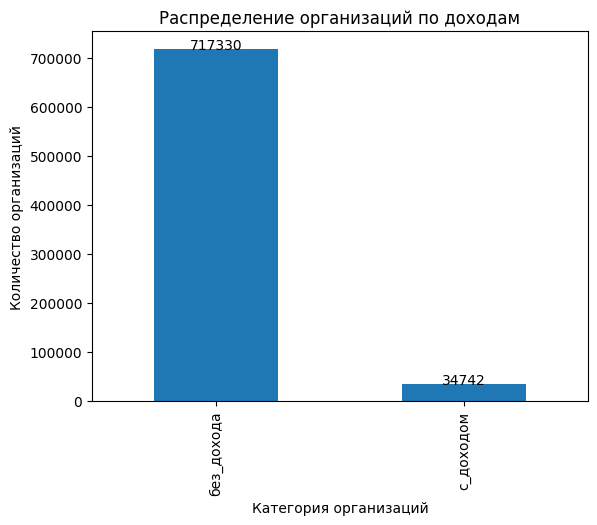

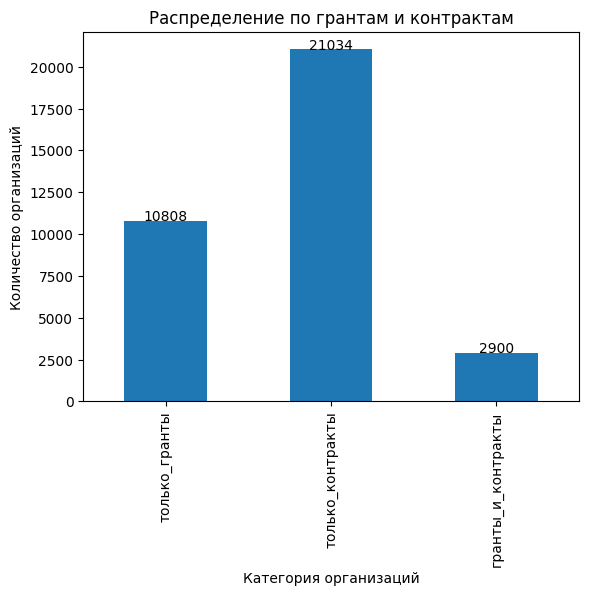

In [7]:
#Визуализация данных о распределении организаций по доходам

# Распределение организаций по доходам
df_full['без_дохода'] = df_full['incomeTotal'].apply(lambda x: 1 if x == 0 else 0)
df_full['с_доходом'] = df_full['incomeTotal'].apply(lambda x: 1 if x > 0 else 0)

ax = df_full[['без_дохода', 'с_доходом']].sum().plot(kind='bar')
plt.xlabel('Категория организаций')
plt.ylabel('Количество организаций')
plt.title('Распределение организаций по доходам')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center')

plt.show()

# Распределение по грантам и контрактам
df_full['только_гранты'] = ((df_full['totalSumGrants'] > 0) & (df_full['totalSumContract'] == 0)).astype(int)
df_full['только_контракты'] = ((df_full['totalSumGrants'] == 0) & (df_full['totalSumContract'] > 0)).astype(int)
df_full['гранты_и_контракты'] = ((df_full['totalSumGrants'] > 0) & (df_full['totalSumContract'] > 0)).astype(int)

ax = df_full[['только_гранты', 'только_контракты', 'гранты_и_контракты']].sum().plot(kind='bar')
plt.xlabel('Категория организаций')
plt.ylabel('Количество организаций')
plt.title('Распределение по грантам и контрактам')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center')

plt.show()

# Удаление временных столбцов
df_full.drop(['без_дохода', 'с_доходом', 'только_гранты', 'только_контракты', 'гранты_и_контракты'], axis=1, inplace=True)

<u>Вывод по Главе 2:</u>
1. При 752072 организаций количество организаций с доходом - 34742 (менее 4,62%).
2. Распределение организаций с доход и без дохода - неравномерно; это нужно учесть при разделени на тестовые и тренеровочные наборы.
3. Большая часть доходов - контракты.
4. При таком малом количестве организаций с доходом, лучше не разбивать организации по статьям.
5. Целевой прихнак incomeTotal разбить на два класса организаций: 1 - с доходом, 0 - без дохода.

In [8]:
# заменим значения признака incomeTotal со значения суммы на бинарное значение: 
# 1 - организация с доходом, 0 - организация без дохода.
df_full['incomeTotal'] = df_full['incomeTotal'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
# удаление признаков, связанных со статьями по доходам и, далее не нужный признак incomeDetail.
df_full = df_full.drop(['totalSumGrants', 'totalSumContract','incomeDetail'], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752072 entries, 0 to 752071
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   addOkved      752072 non-null  object
 1   address       752072 non-null  object
 2   dateLiquid    406460 non-null  object
 3   dateOgrn      752072 non-null  object
 4   fullName      752072 non-null  object
 5   mainOkved     752072 non-null  object
 6   ogrn          752072 non-null  object
 7   opf           752072 non-null  object
 8   predecessors  752072 non-null  object
 9   regionCode    752072 non-null  object
 10  originDate    752072 non-null  object
 11  opfType       752072 non-null  object
 12  incomeTotal   752072 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 74.6+ MB


## Глава 3. Обработка признаков с типом object

### 3.1. Обработка признака regionCode - код региона

При анализировании признаков, связанных с регионом, видно:  
- 25 строк имеют пропуски в наименовании региона;  
- 25 строк имеют нулевые значения в коде региона.

In [10]:
df_full[df_full['regionCode'] == '00'][['regionCode','address']]

,regionCode,address
101323,00,"420108, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА АМИРХАНА, ..."
102989,00,"РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА М.ДЖАЛИЛЯ, ДОМ 3"
191591,00,"420111, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА М.ДЖАЛИЛЯ,..."
217069,00,"420138, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ П..."
217070,00,"420140, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Ю.ФУЧИКА, ..."
218430,00,"420138, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ П..."
218468,00,"420103, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА АМИРХАНА, ..."
218475,00,"420104, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Р.ЗОРГЕ, Д..."
218514,00,"420087, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Р.ЗОРГЕ, Д..."
220009,00,"420101, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА МАВЛЮТОВА,..."


Нулевые значения в коде региона относятся к Республике Татарстан - код 16.  
Заменим пропущенные значения в коде региона на соответствующий код.  
Тип данных кода региона regionCode сделаем int.

In [11]:
# Колиство строк, в котором код - нулевой, - 25. Во всех строках представлен регион - "РЕСПУБЛИКА ТАТАРСТАН".
# Заменим нулевой код региона на значение 16 - "РЕСПУБЛИКА ТАТАРСТАН".
# Тип данных кода региона regionCode сделаем int.

df_full['regionCode'] = df_full['regionCode'].apply(lambda x: int(x))
df_full['regionCode'] = df_full['regionCode'].apply(lambda x: 16 if x == 0 else x)
regionCode_0 = df_full[df_full['regionCode'] == 0]['regionCode'].count()
regionCode_nunique = df_full['regionCode'].nunique()
print(f'Количество строк с нулевым кодом региона: {regionCode_0}')
print(f'Количество уникальных кодов региона: {regionCode_nunique}')

Количество строк с нулевым кодом региона: 0
Количество уникальных кодов региона: 92


Количество уникальных кодов региона: 92.
Чтобы увеличить зависимость вероятности получения грантов от регионов, объединим регионы в округа, которых 9.  
Выделим также коды регионов, в которых есть города миллионники.
Выделим отдельно город республиканского значения.
В итоге вместо 92 кодов останутся 25.

In [12]:
#Регионы городов миллионников
million_cities = ['Москва','Санкт-Петербург','Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск', 'Омск', 
                  'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж', 'Волгоград', 'Краснодар']
region_million_cities = [2,16,23,24,34,36,52,54,55,59,61,63,66,74,77,78]
#Регионы центрального федерального округа
region_cfo = [31,32,33,37,40,44,46,48,50,57,62,67,68,69,71,76]
#Регионы Северо-Западного федерального округа
region_szfo = [10,11,29,35,39,47,51,53,60,83]
#Регионы южного федерального округа
region_ufo = [1,8,30,91,92]
#Регионы Северо-Кавказского федерального округа
region_skfo = [5,6,7,9,15,20,26]
#Регионы Приволжского федерального округа
region_pfo = [12,13,18,21,43,56,58,64,73,81]
#Регионы Уральского федерального округа
region_urfo = [45,72,86,89]
#Регионы Сибирского федерального округа
region_sfo = [4,17,19,22,38,42,70,75,80,84,85,88]
#Регионы Дальневосточного федерального округа
region_dfo = [3,14,25,27,28,41,49,65,75,79,82,87]
#Города республиканского значения
region_resp = [99]

def region_def(region_cod):
    if region_cod in region_million_cities:
        return region_cod
    elif region_cod in region_cfo:
        return 101
    elif region_cod in region_szfo:
        return 102
    elif region_cod in region_ufo:
        return 103
    elif region_cod in region_skfo:
        return 104
    elif region_cod in region_pfo:
        return 105
    elif region_cod in region_urfo:
        return 106
    elif region_cod in region_sfo:
        return 107
    elif region_cod in region_dfo:
        return 108
    elif region_cod in region_resp:
        return 109
    else:
        return 1000

df_full['regionCode'] = df_full['regionCode'].apply(lambda x: region_def(x))

regionCode_nunique = df_full['regionCode'].nunique()
print(f'Количество уникальных кодов региона: {regionCode_nunique}')

Количество уникальных кодов региона: 25


Проанализируем, в каких ТОП5 регионах наибольший процент отношения организаций с доходом к общему количеству организаций региона.

In [13]:
df_grouped = df_full.groupby('regionCode')['incomeTotal'].apply(lambda x: (x == 1).mean() * 100).reset_index(name='percentage')
df_sorted = df_grouped.sort_values(by='percentage', ascending=False)
print('ТОП5 регионов')
print(df_sorted[:5])

ТОП5 регионов
    regionCode  percentage
15          78    7.281538
14          77    6.967624
9           59    6.693698
4           34    6.136325
21         106    5.873494


В итоге, большая часть регионов, в которых наибольший процент организаций с доходом, относится к регонам, в которых есть город-миллионник.

In [ ]:
# удалим не нужные признаки
df_full = df_full.drop(['address'], axis=1)

### 3.2. Обработка признака mainOkved - ОКВЭД

Формат признака mainOkved представляет собой словарь, у каждого из которых есть ключи code (ОКВЭД) и name (наименование ОКВЭД).
Выделим из признака только код.

In [14]:
#Обработка признака mainOkved

#Функция для извлечения значений 'code' из словаря признака
def code_dict(df_dict):
    #аргумент df_dict: значение признака, представляет собой словарь; 
    #                             у каждого словаря есть ключи: code, name, version.    
    #return: код признака
    df_dict = str(df_dict)
    df_dict = df_dict.replace("'", '') #Удаление апострофов из значений в столбце
    df_dict = df_dict[7:] #Удаление первых символов
    df_dict = df_dict.split(',')[0] #Удаление всех символов после запятой включительно
    return df_dict

#Обработка mainOkved (сведения об основном ОКВЭД): выводим только код
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: code_dict(x))

df_full['mainOkved'].head(3)


0       74.1
1    75.25.1
2       None
Name: mainOkved, dtype: object

Для повышения вероятности определения кода основного ОКВЭД  
будем работать только с первой группой кода, т.е. до точки: например, 74.1.1 меняем на 74

In [15]:
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: x.split('.')[0])
df_full['mainOkved'].head(3)

0      74
1      75
2    None
Name: mainOkved, dtype: object

При анализе выявлено, что для ряда организаций ОКВЭД - None.

In [16]:
# данные только с пропущенными значениями основнокго ОКВЭД
df_none_mainOkved = df_full[df_full['mainOkved'] == 'None']['mainOkved'].count()
print(f'Количество строк с отсутствующим ОКВЭД: {df_none_mainOkved}')

Количество строк с отсутствующим ОКВЭД: 203032


Количество строк с отсуствующим ОКВЭД - 27%.  
Вариант удаления данных строк - не допустимо, потеряется большое количество полезных данных.  
Можно собрать по API данные с имеющихся сайтов/платформ, но платно; вариант для димлома не подойдет.

Для опредения отсутствующих ОКВЭД выдвенем гипотизу.  
  
Предположим, что основной ОКВЭД связан с:
* кодом ОПФ и
* названием организации.   

Проверить связи ОКВЭД с кодом ОПФ можно протестировав по критерию "КРИТЕРИЙ ХИ-КВАДРАТ".  

Для работы с названиями организаций можно использовать метод векторизации текста TfidfVectorizer,  
основанный на теории TF-IDF (Term Frequency-Inverse Document Frequency).         
Можно написать функцию, на выходе которого по данным матрицы TF-IDF,  
а также вычислениям косинусного сходства между поисковым запросом и всеми названиями организации, вкючая код ОПФ,  
будет код ОКВЭД.  
Для проверки функции можно выделить 10 случайных подмножеств и проверим её качество.   

Задача трудозатратная для лабораторного ноутбука, поэтому эта задач была выполнена в отдельном файле search_mainOkved.ipynb.   

Последовательность действий:
- сформировать файл search_mainOkved.csv - исходные данные для файла search_mainOkved.ipynb;
- в фале search_mainOkved.ipynb проверить связь ОКВЭД с кодом ОПФ;
- в фале search_mainOkved.ipynb проверить связь ОКВЭД с названием органиазции;
- в фале search_mainOkved.ipynb при положительном варианте проверки сформировать ОКВЭД для соотвесттвующих организаций;
- в фале search_mainOkved.ipynb сформировать файл full_init_data.csv - файл с данными по ОКВЭД;
- загрузить в текущий файл данные из файла full_init_data.csv;
- подгрузить в базу df_full отсутствующие данные по ОКВЭД.
  
Проверка по критерию "КРИТЕРИЙ ХИ-КВАДРАТ" показал, что "Между признаками "mainOkved" и "opf" существует статистически значимая связь".   
Проверка связи ОКВЭД c названиями организации показал среднюю вероятность предсказаний - 64%.  
Величина небольшая, но для диплома гипотизу возьмем за основу.  
Для увеличения вероятнсти предсказания в основном файле проекта "diplom_glazyrin.ipynb" коды ОКВЭД объединим в группы по классификации ОКВЭД 2023 года.

In [27]:
# в качестве исходных данных для формирования ОКВЭД выделим следующие признаки: 'ogrn','fullName','mainOkved','opf'
# cохранение DataFrame в файл CSV
df_full[['ogrn','fullName','mainOkved','opf']].to_csv('data/search_mainOkved.csv', index=False)

In [17]:
# загрузим данные из файла full_init_data.csv
df_mainOkved_none = pd.read_csv("data/full_init_data.csv")
df_mainOkved_none.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203032 entries, 0 to 203031
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   ogrn               203032 non-null  int64
 1   predict_mainOkved  203032 non-null  int64
dtypes: int64(2)
memory usage: 3.1 MB


Из файла full_init_data.csv были получены следующие данные:
- ogrn - ОГРН органиазции;
- predict_mainOkved - прогнозные значения ОКВЭД

In [18]:
#Подготовим признак mainOkved базы df_full: обнулим пропущенные значения и поменяем тип данных на Int
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: '0' if x == 'None' else x)
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: int(x))

In [19]:
#Заменим нулевые ОКВЭД на прогнозные значения для соответствующих организаций.

def mainOkved_none_def(ogrn_arg):
    #аргумент ogrn_arg: ОГРН организации    
    #return: ОКВЭД
    mainOkved_new = df_mainOkved_none[df_mainOkved_none['ogrn'] == int(ogrn_arg)]['predict_mainOkved'].values[0]
    return mainOkved_new

df_full['mainOkved'] = df_full.apply(lambda x: x['mainOkved'] if x['mainOkved'] > 0 else mainOkved_none_def(x['ogrn']), axis=1)

df_full['mainOkved'].head(5)

0    74
1    75
2    74
3    91
4    70
Name: mainOkved, dtype: int64

Для увеличения вероятнсти предсказания коды ОКВЭД объединим в группы по классификации ОКВЭД 2023 года.

In [20]:
#Обработка mainOkved

#Словарь ОКВЭД
mainOkved_dict = dict()
mainOkved_dict = {101: ['01','02','03'], 
                  102: ['05','06','07','08','09'], 
                  103: ['10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','33'],
                  104: ['35'],                  
                  105: ['36','37','38','39'],
                  106: ['41','42','43'],
                  107: ['45','46','47'],
                  108: ['49','50','51','52','53'],
                  109: ['55','56'],
                  110: ['58','59','60','61','62','63'],
                  111: ['64','65','66'],
                  112: ['68'],
                  113: ['69','70','71','72','73','74','75'],
                  114: ['77','78','79','80','81','82'],
                  115: ['84'],
                  116: ['85'],
                  117: ['86','87','88'],
                  118: ['90','91','92','93'],
                  119: ['94','95','96'],
                  120: ['97','98'],
                  121: ['99']}

def mainOkved_def(mainOkved_cod):
    #аргумент mainOkved_cod: ОКВЭД организации    
    #return: код группы по классификации
    for key, values in mainOkved_dict.items():
        if mainOkved_cod in values:
            return key
    key_none = '10' + mainOkved_cod # Код для случая, если ОКВЭД отсутствует в словаре mainOkved_dict
    return key_none

#Оставляем только первый символ до точки
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: str(x))
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: mainOkved_def(x))
df_full['mainOkved'] = df_full['mainOkved'].apply(lambda x: int(x))

df_full['mainOkved'].head(3)

0    113
1    113
2    113
Name: mainOkved, dtype: int64

Количество ОКВЭД заменили на группы: с 99 до 21.
Проанализируем, в каких ТОП5 ОКВЭД наибольший процент отношения организаций с доходом к общему количеству организаций с данным ОКВЭД.

In [21]:
df_grouped = df_full.groupby('mainOkved')['incomeTotal'].apply(lambda x: (x == 1).mean() * 100).reset_index(name='percentage')
df_sorted = df_grouped.sort_values(by='percentage', ascending=False)
print('ТОП5 групп ОКВЭД')
df_sorted.head(5)


ТОП5 групп ОКВЭД


,mainOkved,percentage
8,109,25.729927
15,116,18.127544
16,117,13.424995
4,105,11.867583
6,107,10.099464


In [34]:
# удалим не нужные признаки
df_full = df_full.drop(['ogrn', 'fullName', 'fullName', 'opf'], axis=1)

### 3.3. Обработка признаков с датами

Признаки, связанные с датами
1. originDate: дата регистрации организаций
2. dateLiquid: дата ликвидации юрлица

Создадим наиболее важный признак - возраст организации.

In [23]:
# обработка дат

# признак dateLiquid имеет пропущенные значения для действующих организаций
# для действующих организаций значение признака dateLiquid поставим в '0'
df_full['dateLiquid'] = df_full['dateLiquid'].fillna('0')

# функция для извлечения года из признака
def date_dict(df_date):
    #аргумент: значение признака, которое представляет собой дату следующего вида - {'$date': '2012-12-17T00:00:00.000Z'}
    #return: год (тип float)    
    if df_date != '0':
        df_date = df_date.replace("'", '') #Удаление апострофов из значений в столбце
        df_date = df_date[7:] #Удаление первых символов
        df_date = df_date.split('-')[0] #Удаление всех символов после запятой включительно
        return int(df_date)
    else:
        return int(df_date)

# признаки originDate и dateLiquid представим в виде года
df_full['originDate'] = df_full['originDate'].apply(lambda x: date_dict(str(x)))
df_full['dateLiquid'] = df_full['dateLiquid'].apply(lambda x: date_dict(str(x)))

# функция для расчета нового значения diffYear
def calculate_new_value(row):
    #аргумент: строка DataFrmae df_full - данные от органиазции
    #return: год (тип float) 
    if row['dateLiquid'] != 0: # для действующей организации
        return row['dateLiquid'] - row['originDate']
    else:
        current_date = datetime.now().year
        return int(str(current_date)) - row['originDate']

# применяем функцию к каждой строке DataFrame и создаем новый столбец
df_full['diffYear'] = df_full.apply(lambda row: calculate_new_value(row), axis=1)

# проанализируем даты базы данных
df_full[['originDate','dateLiquid','diffYear']].describe()

,originDate,dateLiquid,diffYear
count,752072.000000,752072.000000,752072.000000
mean,2004.349588,1087.709941,13.022774
std,9.207059,1003.001238,9.176799
min,1881.000000,0.000000,-2.000000
25%,1999.000000,0.000000,6.000000
50%,2004.000000,2006.000000,11.000000
75%,2011.000000,2013.000000,18.000000
max,2021.000000,2021.000000,138.000000


Видно, что имеются неадекватные данные: возраст органиазции меньше нуля.  
Удалим строки, у которых возраст организации меньше нуля.

In [24]:
# удалим строки, у которых возраст организации меньше нуля
df_full = df_full[(df_full['diffYear'] >= 0)]
df_full[['originDate','dateLiquid','diffYear']].describe()

,originDate,dateLiquid,diffYear
count,752068.000000,752068.000000,752068.000000
mean,2004.349571,1087.705059,13.022853
std,9.207080,1003.001671,9.176760
min,1881.000000,0.000000,0.000000
25%,1999.000000,0.000000,6.000000
50%,2004.000000,2006.000000,11.000000
75%,2011.000000,2013.000000,18.000000
max,2021.000000,2021.000000,138.000000


Text(0, 0.5, '')

<Figure size 1500x600 with 0 Axes>

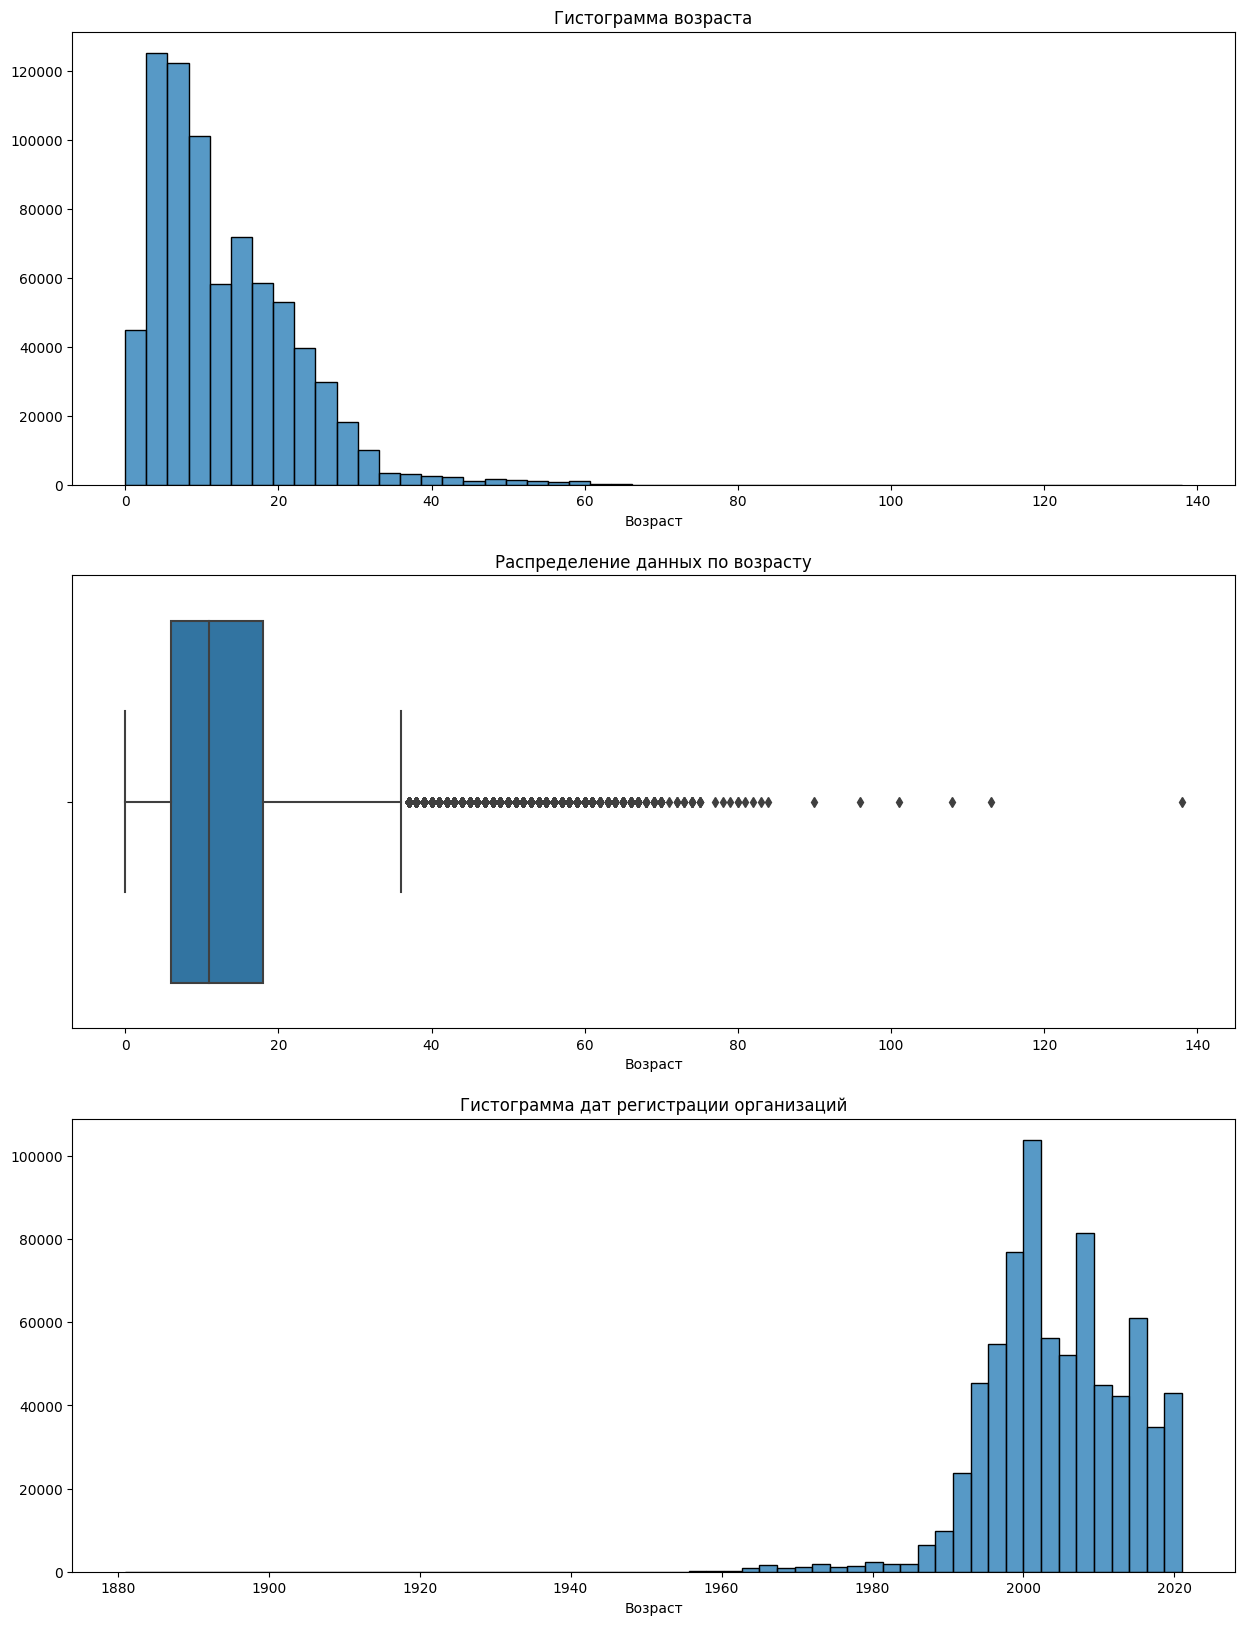

In [29]:
#Визиализируем данные

# Установить размер графика
plt.figure(figsize=(15, 6))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
sns.histplot(
    data=df_full,
    x='diffYear',
    bins=50,   
    ax=axes[0]
);
axes[0].set_title('Гистограмма возраста')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('')

sns.boxplot(
    data=df_full,
    x='diffYear',
    ax=axes[1]
);
axes[1].set_title('Распределение данных по возрасту')
axes[1].set_xlabel('Возраст')

sns.histplot(
    data=df_full,
    x='originDate',
    bins=60,   
    ax=axes[2]
);
axes[2].set_title('Гистограмма дат регистрации организаций')
axes[2].set_xlabel('Возраст')
axes[2].set_ylabel('')

По визуализации видно:
1. распределение возраста не нормальное;
2. верхний квартиль - 38 лет, далее - большое количество выбросов;
3. регистрация организаций начинается с конца 19 века.
  
Заметим, что целевой признак класса 1 начинается с 1964 года.  
С точки зрения получения грантов интерес будут представлять органиазции, регистрированные к концу 80-х годов 20 века.

In [30]:
# удалим строки, регистрация органиазций которых старше 1987 года.
df_full = df_full[df_full['originDate'] > 1987]
df_full.shape

(733471, 14)

Удаленные данные - меньше 2,5%.

Text(0, 0.5, '')

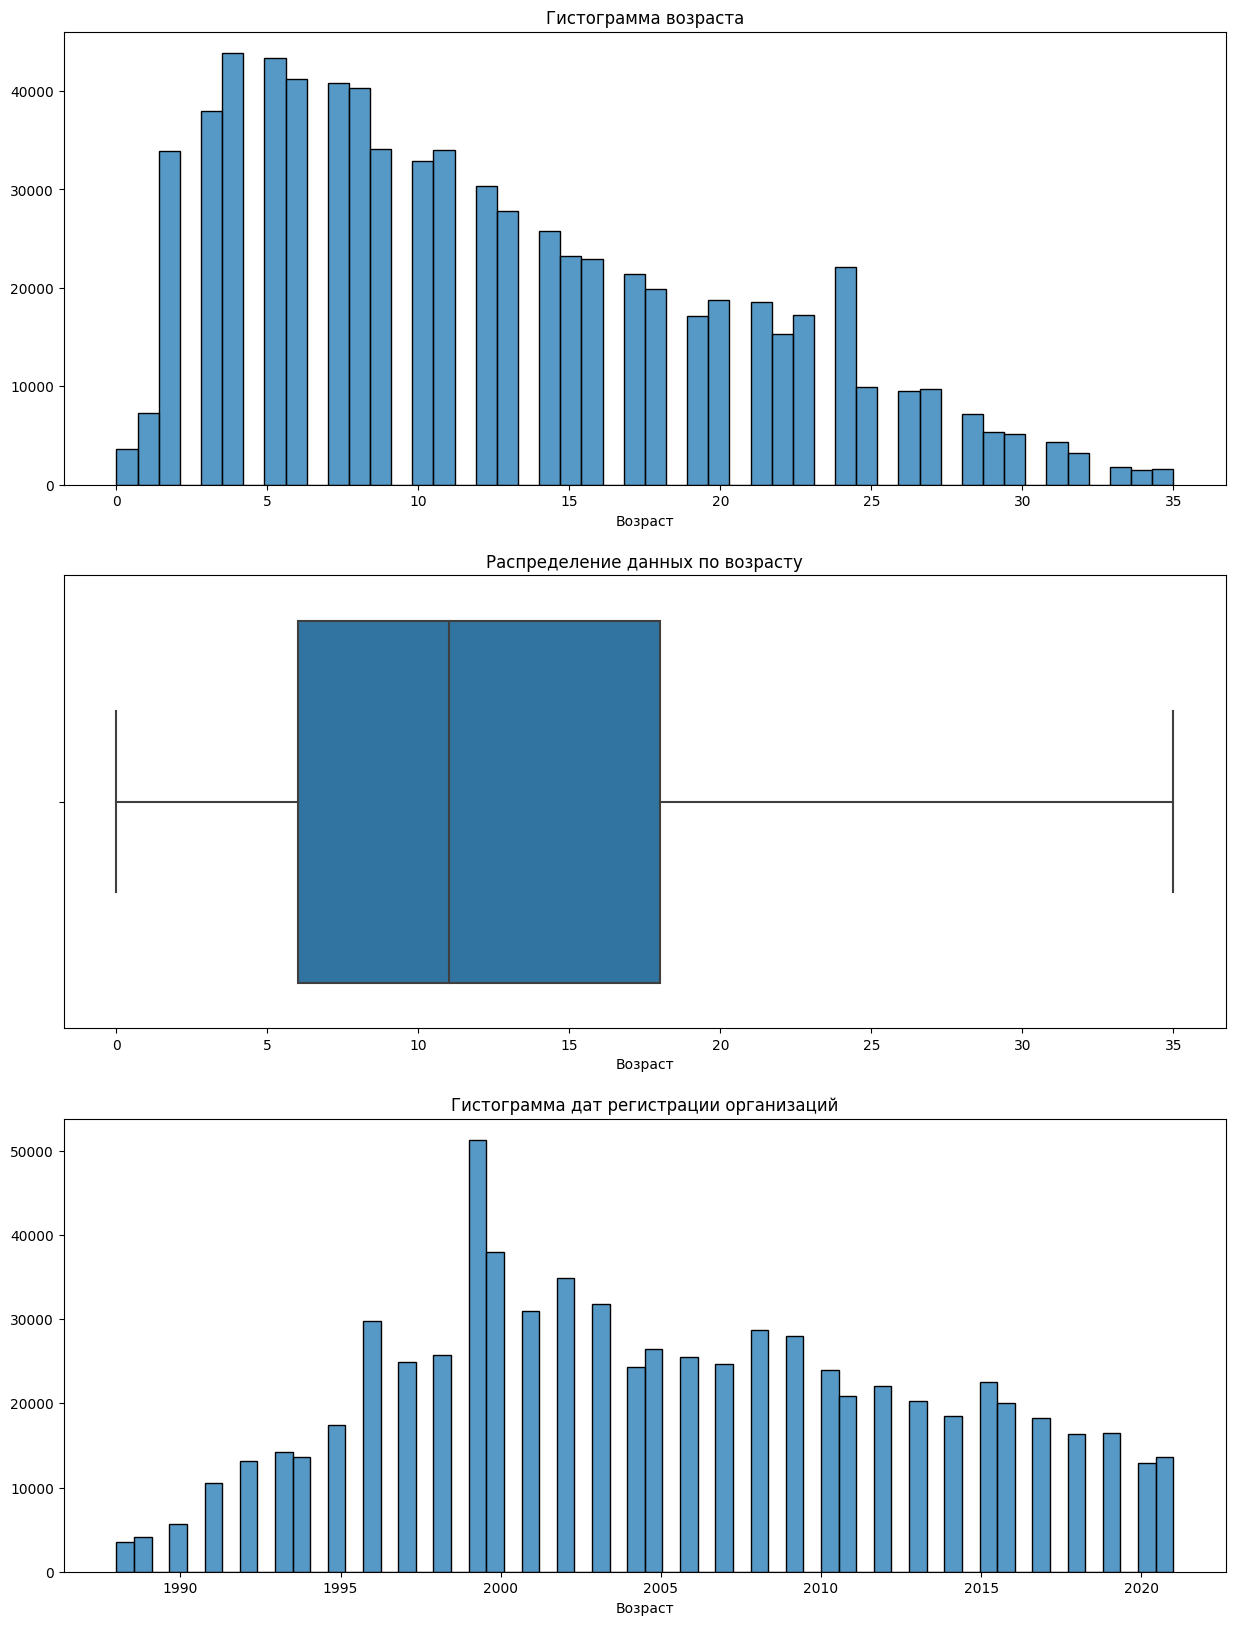

In [32]:
#Визиализируем данные

# Установить размер графика
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 20))
sns.histplot(
    data=df_full,
    x='diffYear',
    bins=50,   
    ax=axes[0]
);
axes[0].set_title('Гистограмма возраста')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('')

sns.boxplot(
    data=df_full,
    x='diffYear',
    ax=axes[1]
);
axes[1].set_title('Распределение данных по возрасту')
axes[1].set_xlabel('Возраст')

sns.histplot(
    data=df_full,
    x='originDate',
    bins=60,   
    ax=axes[2]
);
axes[2].set_title('Гистограмма дат регистрации организаций')
axes[2].set_xlabel('Возраст')
axes[2].set_ylabel('')

In [33]:
# удалим не нужные признаки
df_full = df_full.drop(['originDate','dateLiquid'], axis=1)

### 3.4. Обработка бинарных признаков

Перевод значений признаков в бинарный тип:
1. predecessors: предшественники; 1 - имеется, 0 - нет
2. addOkved: дополнительный ОКВЭД - наличие дополнительных ОКВЭД: 1 - есть, 0 - нет

In [36]:
#Перевод значений признаков в бинарный тип

# Функция для извлечения значений 'code' из списка словарей признака
def code_list(df_list):
    #аргумент: значение признака, представляет собой список, 
    #                             элементы которого словари; 
    #                             у каждого словаря есть ключи: code, name, version.
    #return: 1 - список не пустой, 0 - список пустой
    addOkved_list = ast.literal_eval(df_list)
    if len(addOkved_list) > 0:
        return 1
    else:
        return 0

#Обработка addOkved (дополнительный ОКВЭД): наличие дополнительных ОКВЭД: 1 - есть, 0 - нет
df_full['addOkved'] = df_full['addOkved'].apply(lambda x: code_list(str(x)))

#predecessors: предшественники; 1 - имеется, 0 - нет
df_full['predecessors'] = df_full['predecessors'].apply(lambda x: 0 if x == '[]' else 1)


df_full[['predecessors','addOkved']].head(5)

,predecessors,addOkved
0,1,1
1,1,1
2,1,0
3,1,0
4,1,0
...,...,...
752067,1,1
752068,1,1
752069,1,0
752070,1,1


In [37]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   addOkved      733471 non-null  int64 
 1   address       733471 non-null  object
 2   dateOgrn      733471 non-null  object
 3   fullName      733471 non-null  object
 4   mainOkved     733471 non-null  int64 
 5   opf           733471 non-null  object
 6   predecessors  733471 non-null  int64 
 7   regionCode    733471 non-null  int64 
 8   opfType       733471 non-null  object
 9   incomeTotal   733471 non-null  int64 
 10  diffYear      733471 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 67.2+ MB


<AxesSubplot: >

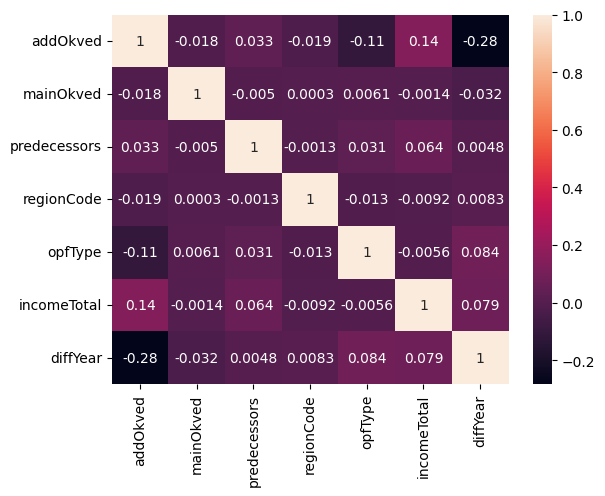

In [51]:
sns.heatmap(df_full.corr(), annot=True)

In [25]:
df_full['mainOkved'].unique()

array([ 113,  118,  108,  116,  101,  114,  119,  111,  112,  117,  105,
        106,  103,  107,  110,  115,  104, 1067, 1040,  109,  102,  121,
        120], dtype=int64)

In [52]:
#Закодируем mainOkved
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

encoder = ce.OneHotEncoder(cols=['mainOkved'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_full['mainOkved'])
df_full = pd.concat([df_full, type_bin], axis=1)

df_full.iloc[:5,9:15]

,mainOkved_108.0,mainOkved_116.0,mainOkved_101.0,mainOkved_114.0,mainOkved_119.0,mainOkved_111.0
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [20]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   mainOkved         733471 non-null  int64
 2   predecessors      733471 non-null  int64
 3   regionCode        733471 non-null  int64
 4   opfType           733471 non-null  int64
 5   incomeTotal       733471 non-null  int64
 6   diffYear          733471 non-null  int64
 7   mainOkved_113.0   733471 non-null  int64
 8   mainOkved_118.0   733471 non-null  int64
 9   mainOkved_108.0   733471 non-null  int64
 10  mainOkved_116.0   733471 non-null  int64
 11  mainOkved_101.0   733471 non-null  int64
 12  mainOkved_114.0   733471 non-null  int64
 13  mainOkved_119.0   733471 non-null  int64
 14  mainOkved_111.0   733471 non-null  int64
 15  mainOkved_112.0   733471 non-null  int64
 16  mainOkved_117.0   733471 non-null  int64
 17  mainOkved_

In [53]:
#Закодируем regionCode
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

encoder = ce.OneHotEncoder(cols=['regionCode'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_full['regionCode'])
df_full = pd.concat([df_full, type_bin], axis=1)

df_full.iloc[:5,32:40]

,regionCode_77.0,regionCode_102.0,regionCode_107.0,regionCode_23.0,regionCode_101.0,regionCode_66.0,regionCode_104.0,regionCode_63.0
0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0


In [29]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 56 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   mainOkved         733471 non-null  int64
 2   predecessors      733471 non-null  int64
 3   successors        733471 non-null  int64
 4   regionCode        733471 non-null  int64
 5   opfType           733471 non-null  int64
 6   incomeTotal       733471 non-null  int64
 7   diffYear          733471 non-null  int64
 8   mainOkved_113.0   733471 non-null  int64
 9   mainOkved_118.0   733471 non-null  int64
 10  mainOkved_108.0   733471 non-null  int64
 11  mainOkved_116.0   733471 non-null  int64
 12  mainOkved_101.0   733471 non-null  int64
 13  mainOkved_114.0   733471 non-null  int64
 14  mainOkved_119.0   733471 non-null  int64
 15  mainOkved_111.0   733471 non-null  int64
 16  mainOkved_112.0   733471 non-null  int64
 17  mainOkved_

In [54]:
#Закодируем opfType
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

df_full['opfType'].unique()

def opfType_def(arg):
       opfType_dict = {'Некоммерческие партнерства': 1, 'Ассоциации и бюро': 2,
              'Общественные организации': 3, 'Кооперативы и товарищества': 4,
              'Учреждения': 5, 'Фонды': 6, 'Автономные некоммерческие организации': 7,
              'Профессиональные союзы': 8, 'Некоммерческие организации': 9, 'Другое': 10,
              'Общины малочисленных народов': 11, 'Религиозные организации': 12,
              'Политические партии': 13, 'Казачьи общества': 14}
       return opfType_dict[arg]

df_full['opfType'] = df_full['opfType'].apply(lambda x: opfType_def(x))

encoder = ce.OneHotEncoder(cols=['opfType'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(df_full['opfType'])
df_full = pd.concat([df_full, type_bin], axis=1)

df_full.iloc[:5,57:71]

,opfType_3.0,opfType_4.0,opfType_5.0,opfType_6.0,opfType_7.0,opfType_8.0,opfType_9.0,opfType_10.0,opfType_11.0,opfType_12.0,opfType_13.0,opfType_14.0
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0


In [55]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 69 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   mainOkved         733471 non-null  int64
 2   predecessors      733471 non-null  int64
 3   regionCode        733471 non-null  int64
 4   opfType           733471 non-null  int64
 5   incomeTotal       733471 non-null  int64
 6   diffYear          733471 non-null  int64
 7   mainOkved_113.0   733471 non-null  int64
 8   mainOkved_118.0   733471 non-null  int64
 9   mainOkved_108.0   733471 non-null  int64
 10  mainOkved_116.0   733471 non-null  int64
 11  mainOkved_101.0   733471 non-null  int64
 12  mainOkved_114.0   733471 non-null  int64
 13  mainOkved_119.0   733471 non-null  int64
 14  mainOkved_111.0   733471 non-null  int64
 15  mainOkved_112.0   733471 non-null  int64
 16  mainOkved_117.0   733471 non-null  int64
 17  mainOkved_

In [32]:
#Закодируем diffYear
#Запустив последовательно варианты кодирования (порядковое, ONE-HOT ENCODING, бинарное), лучшая оценка была в однократном кодировании.

#encoder = ce.OneHotEncoder(cols=['diffYear'], use_cat_names=True) # указываем столбец для кодирования
#type_bin = encoder.fit_transform(df_full['diffYear'])
#df_full = pd.concat([df_full, type_bin], axis=1)

#df_full.iloc[:5,70:80]

,diffYear_2.0,diffYear_4.0,diffYear_17.0,diffYear_12.0,diffYear_18.0,diffYear_15.0,diffYear_14.0,diffYear_10.0,diffYear_3.0,diffYear_21.0
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [31]:
#df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 67 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   predecessors      733471 non-null  int64
 2   incomeTotal       733471 non-null  int64
 3   diffYear          733471 non-null  int64
 4   mainOkved_113.0   733471 non-null  int64
 5   mainOkved_118.0   733471 non-null  int64
 6   mainOkved_108.0   733471 non-null  int64
 7   mainOkved_116.0   733471 non-null  int64
 8   mainOkved_101.0   733471 non-null  int64
 9   mainOkved_114.0   733471 non-null  int64
 10  mainOkved_119.0   733471 non-null  int64
 11  mainOkved_111.0   733471 non-null  int64
 12  mainOkved_112.0   733471 non-null  int64
 13  mainOkved_117.0   733471 non-null  int64
 14  mainOkved_105.0   733471 non-null  int64
 15  mainOkved_106.0   733471 non-null  int64
 16  mainOkved_103.0   733471 non-null  int64
 17  mainOkved_

In [56]:
#Удаление столбцов/признаков, значение которых объективно не могут влияют на поставленную задачу, на целевой признак
df_full = df_full.drop(['mainOkved','regionCode','opfType'], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733471 entries, 0 to 752071
Data columns (total 66 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   addOkved          733471 non-null  int64
 1   predecessors      733471 non-null  int64
 2   incomeTotal       733471 non-null  int64
 3   diffYear          733471 non-null  int64
 4   mainOkved_113.0   733471 non-null  int64
 5   mainOkved_118.0   733471 non-null  int64
 6   mainOkved_108.0   733471 non-null  int64
 7   mainOkved_116.0   733471 non-null  int64
 8   mainOkved_101.0   733471 non-null  int64
 9   mainOkved_114.0   733471 non-null  int64
 10  mainOkved_119.0   733471 non-null  int64
 11  mainOkved_111.0   733471 non-null  int64
 12  mainOkved_112.0   733471 non-null  int64
 13  mainOkved_117.0   733471 non-null  int64
 14  mainOkved_105.0   733471 non-null  int64
 15  mainOkved_106.0   733471 non-null  int64
 16  mainOkved_103.0   733471 non-null  int64
 17  mainOkved_

In [57]:
# зафксируем random_state
random_state = 42

In [58]:
# Разделение на признаки и целевую переменную
X = df_full.drop('incomeTotal', axis=1)  # Признаки (все столбцы, кроме целевой переменной)
y = df_full['incomeTotal']               # Целевая переменная

#Стратифицированное разделение на train и test выборки
#Размер тестовой выборки составляет 20% от всего набора данных
#Передаем параметр stratify=y,
#   который указывает на использование стратификации на основе целевой переменной y,
#   чтобы сохранить баланс классов в обоих выборках.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

# Вывод размерностей полученных выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (586776, 65)
Размер тестовой выборки: (146695, 65)


Precision (точность), или PPV (Positive Predictive Value) — это доля объектов, которые действительно являются положительными, по отношению ко всем объектам, названным моделью положительными.
Интерпретация: способность отделить класс 1 от класса 0. Чем больше precision, тем меньше ложных попаданий. То есть чем ближе precision к 1, тем меньше вероятность модели допустить ошибку I рода.
Используется в задачах, где важно минимальное количество ложноположительных срабатываний модели.
Можно использовать на несбалансированных выборках.

Recall (полнота), или TPR (True Positive Rate) — это доля объектов, названных классификатором положительными, по отношению ко всем объектам положительного класса.
Интерпретация: способность модели обнаруживать класс 1 вообще, то есть охват класса 1. Заметьте, что метрика зависит от количества ложноотрицательных срабатываний. То есть чем ближе recall к 1, тем меньше вероятность модели допустить ошибку II рода.
Можно использовать на несбалансированных выборках.

(F-мера) — это взвешенное среднее гармоническое между precision и recall:
Метрика равна своему максимуму (1), если и precision, и recall равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания). Но если хотя бы одна из метрик будет близка к 0, то и F будет близка к 0. 
Отсутствие интерпретации не даёт интуитивного понимания человеку, не знакомому с этой метрикой.

print(metrics.classification_report(y, y_pred2))

<center> РЕЗУЛЬТАТЫ БЕЗ ПРЕДВАРИТЕЛЬНЫХ НАСТРОЕК

In [72]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=random_state, max_iter=2000)
#Обучаем модель
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train)

precision = precision_score(y_test, y_pred, pos_label=1)
precision_train = precision_score(y_train, y_pred_train, pos_label=1)
print("Precision for class 1:", precision)
print("precision_train for class 1:", precision_train)
print(metrics.classification_report(y_test, y_pred))

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [61]:
#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    random_state=random_state #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)

y_pred = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

#Выводим значения метрики
precision = precision_score(y_test, y_pred, pos_label=1)
precision_train = precision_score(y_train, y_pred_train, pos_label=1)
print("Precision for class 1:", precision)
print("precision_train for class 1:", precision_train)
print(metrics.classification_report(y_test, y_pred))

Precision for class 1: 0.38422247446083996
precision_train for class 1: 0.8447571493418067
              precision    recall  f1-score   support

           0       0.96      0.99      0.97    139805
           1       0.38      0.10      0.16      6890

    accuracy                           0.95    146695
   macro avg       0.67      0.55      0.57    146695
weighted avg       0.93      0.95      0.94    146695



<center> РЕЗУЛЬТАТЫ C НАСТРОЙКАМИ

In [83]:
#Параметры для логистической регрессии
penalty_choice = ('l2', 'none')
solver_choice = ('lbfgs', 'sag')
C_choice = (0.05, 0.06)


param_grid_lr = {'penalty': penalty_choice , # тип регуляризации
              'solver': solver_choice, # алгоритм оптимизации
               'C': C_choice # уровень силы регурялизации
                }


space_lr = {'penalty': hp.choice('penalty', penalty_choice) , # тип регуляризации
          'solver': hp.choice('solver', solver_choice), # алгоритм оптимизации
          'C': hp.choice('C', C_choice) # уровень силы регурялизации
          }

#Параметры для сдучайного леса
#param_grid_rfc = {'min_samples_leaf': list(np.linspace(5, 100, 10, dtype=int)),
#              'max_depth': list(np.linspace(1, 30, 10, dtype=int)),
#              'criterion':['entropy','gini']
#                }
param_grid_rfc = {'min_samples_leaf': list(np.linspace(5, 100, 20, dtype=int)),
              'max_depth': list(np.linspace(20, 30, 10, dtype=int)),
              'criterion':['entropy','gini']
                }

criterion_choice = ('entropy','gini')

space_rfc={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
      'max_depth' : hp.quniform('max_depth', 1, 30, 1),
      'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 100, 10),
      'criterion': hp.choice('criterion', criterion_choice)
      }

In [80]:
#ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ + GridSearchCV

grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=2000), 
    param_grid=param_grid_lr, 
    cv=2, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 

# Получаем лучшую модель с лучшими гиперпараметрами
best_model = grid_search.best_estimator_

# Получаем прогнозы на тестовой выборке
y_pred_test_log_reg = best_model.predict(X_test)
y_pred_train_log_reg = best_model.predict(X_train)

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

print('Precision на тестовом наборе для класса 1: {:.2f}'.format(metrics.precision_score(y_test, y_pred_test_log_reg, pos_label=1)))
print('Precision на тренеровочном наборе для класса 1: {:.2f}'.format(metrics.precision_score(y_train, y_pred_train_log_reg, pos_label=1)))
print(metrics.classification_report(y_test, y_pred_test_log_reg))


c:\Users\glaz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\glaz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


CPU times: total: 4min 54s
Wall time: 19min 12s
Наилучшие значения гиперпараметров: {'C': 0.05, 'penalty': 'none', 'solver': 'lbfgs'}
Precision на тестовом наборе для класса 1: 0.55
Precision на тренеровочном наборе для класса 1: 0.52
              precision    recall  f1-score   support

           0       0.95      1.00      0.98    139805
           1       0.55      0.04      0.07      6890

    accuracy                           0.95    146695
   macro avg       0.75      0.52      0.52    146695
weighted avg       0.94      0.95      0.93    146695



In [84]:
#СЛУЧАЙНЫЕ ЛЕС + GridSearchCV
            
grid_search_tree = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state), 
    param_grid=param_grid_rfc, 
    cv=2, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train) 
y_test_pred = grid_search_tree.predict(X_test)
print('Precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred, pos_label=1)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

In [ ]:
# Получаем значения важности признаков
importances = best_model.feature_importances_

# Создаем список признаков и их важностей
features_importance = list(zip(X_train.columns, importances))

# Сортируем список по важности признаков в порядке убывания
features_importance.sort(key=lambda x: x[1], reverse=True)

# Получаем три лучших признака
top_features = [x[0] for x in features_importance[:2]]

# Выводим результат
print("Три лучших признака:", top_features)